In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data Import

In [122]:
data = pd.read_csv('medicaid_spending_usafacts.csv')
data = pd.DataFrame(data.iloc[0])
data = data.iloc[1:]
data.reset_index(inplace=True)
data.columns = ['date','spending']
data['spending'] = data['spending'].astype(float)
data['date'] = pd.to_datetime(data['date'].astype(str) + '-01-01')
data.head()

,date,spending
0,1970-01-01,5.092223e+09
1,1971-01-01,6.542492e+09
2,1972-01-01,8.008078e+09
3,1973-01-01,9.371525e+09
4,1974-01-01,1.078707e+10


In [70]:
train = data[data['date']<'2018-01-01']
valid = data[data['date']>'2017-01-01']
train.set_index('date',inplace = True)
valid.set_index('date',inplace=True)
valid

,spending
date,
2018-01-01,6.160970e+11
2019-01-01,6.269300e+11
2020-01-01,6.827060e+11
2021-01-01,7.482187e+11
2022-01-01,8.242363e+11


# EDA

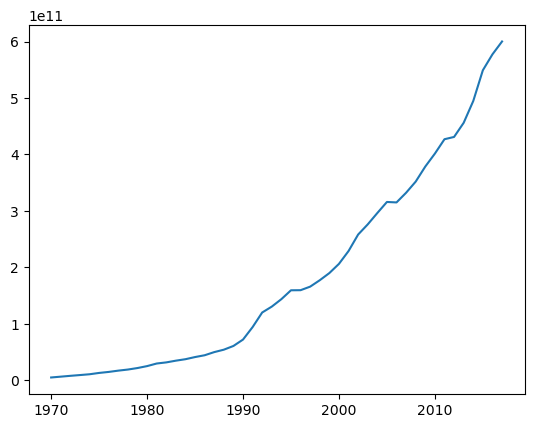

In [71]:
plt.plot(train)

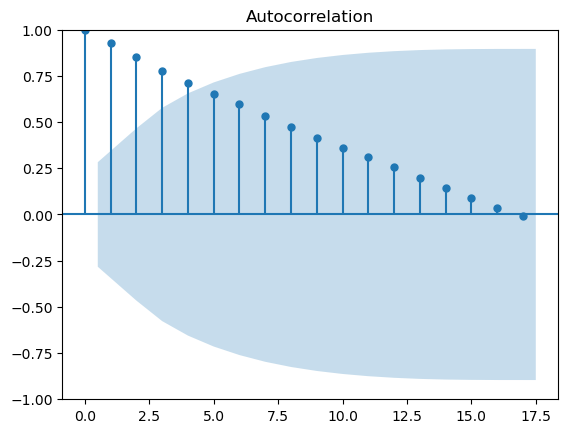

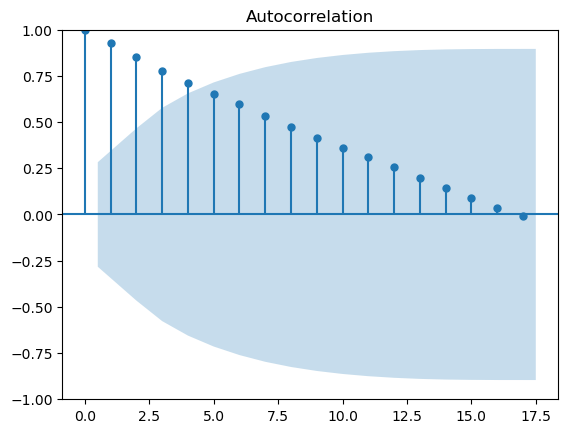

In [72]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train)

In [73]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['spending'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: 1.083494
p-value: 0.995073


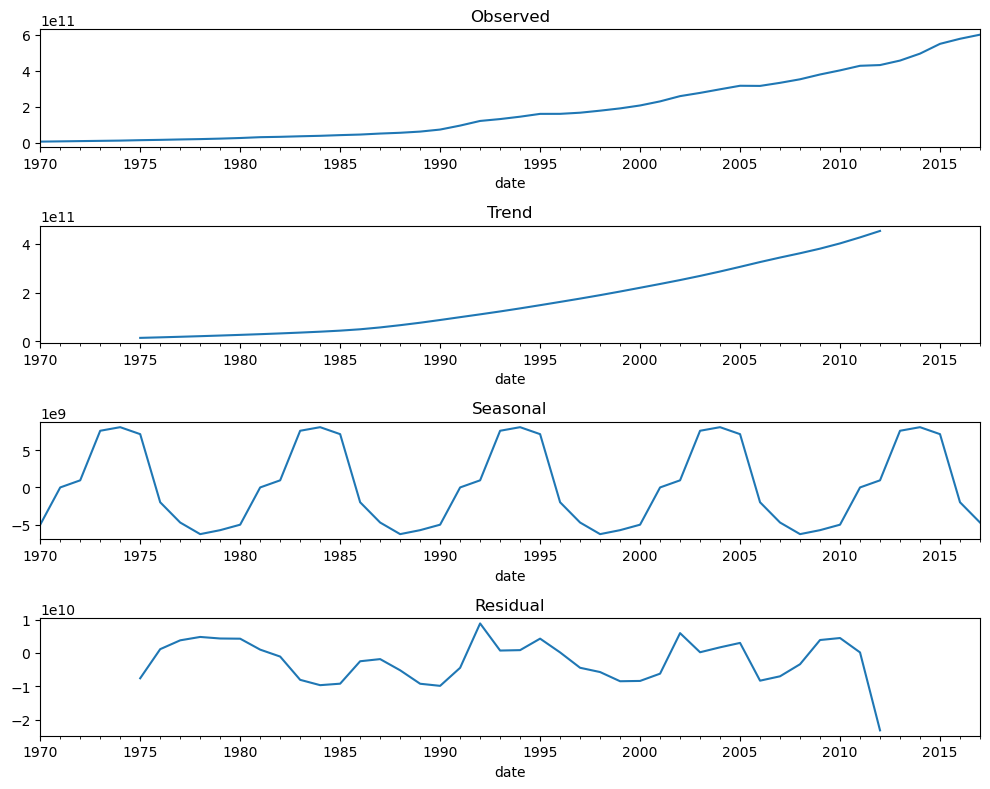

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

data = data.asfreq('YS')

decomposition = seasonal_decompose(train['spending'], model='additive',period = 10)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()


# Model Training

#### Holt-winter

In [77]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hw_ad = ExponentialSmoothing(train['spending'],trend = 'add').fit()
pre_hw_ad = model_hw.forecast(5)

In [78]:
model_hw_mul = ExponentialSmoothing(train['spending'],trend = 'mul').fit()
pre_hw_mul = model_hw_mul.forecast(5)

#### ARIMA

In [84]:
from pmdarima import auto_arima

# Run the auto_arima function to find the best ARIMA parameters
model_arima = auto_arima(train['spending'], seasonal=False, stepwise=True, trace=True,
                   error_action='ignore', suppress_warnings=True)

# model.summary() will give you a summary of the best model found by auto_arima
print(model_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2244.325, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2244.548, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2239.443, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2242.486, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2244.709, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=2244.113, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2240.168, Time=0.00 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 0.339 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1116.721
Date:                Thu, 25 Apr 2024   AIC                

In [87]:
pre_arima = model_arima.predict(n_periods=5)

#### Prophet

In [106]:
train_p = train.resample('MS').interpolate(method='spline',order = 2)
train_p = train_p.reset_index()
train_p.columns = ['ds','y']
train_p = train_p[train_p['ds']>'2004-12-31']

In [109]:
from prophet import Prophet
m = Prophet()
m.fit(train_p)

future = m.make_future_dataframe(periods=5,freq='YS')
forecast = m.predict(future)
result = forecast[['ds','yhat']]

pre_pro = result[result['ds']>"2017-01-01"]['yhat']

00:10:21 - cmdstanpy - INFO - Chain [1] start processing
00:10:21 - cmdstanpy - INFO - Chain [1] done processing


# Evaluation

In [120]:
from sklearn.metrics import mean_squared_error
print('ARIMA',np.sqrt(mean_squared_error(valid['spending'],pre_arima)))
print('Holt-Winter Additive Trend',np.sqrt(mean_squared_error(valid['spending'],pre_hw_ad)))
print('Holt-Winter Multiplicative Trend',np.sqrt(mean_squared_error(valid['spending'],pre_hw_mul)))
print('Prophet',np.sqrt(mean_squared_error(valid['spending'],pre_pro)))

ARIMA 33105979862.391586
Holt-Winter Additive Trend 39855492039.172554
Holt-Winter Multiplicative Trend 28878948875.201706
Prophet 40389232652.79656


# Refit the optimal model

In [146]:
from pmdarima import auto_arima

# Run the auto_arima function to find the best ARIMA parameters
model = auto_arima(data['spending'], seasonal=False, stepwise=True, trace=True,
                   error_action='ignore', suppress_warnings=True)

# model.summary() will give you a summary of the best model found by auto_arima
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2505.780, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2507.509, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2507.641, Time=0.00 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2504.735, Time=0.00 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2509.602, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.139 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1251.367
Date:                Tue, 30 Apr 2024   AIC                           2504.735
Time:                        21:31:45   BIC                           2506.667
Sample:                             0   HQIC                          2505.473
               

In [147]:
arima_predict = model.predict(n_periods=10)
arima_predict

53    9.002540e+11
54    9.762717e+11
55    1.052289e+12
56    1.128307e+12
57    1.204325e+12
58    1.280342e+12
59    1.356360e+12
60    1.432378e+12
61    1.508395e+12
62    1.584413e+12
dtype: float64

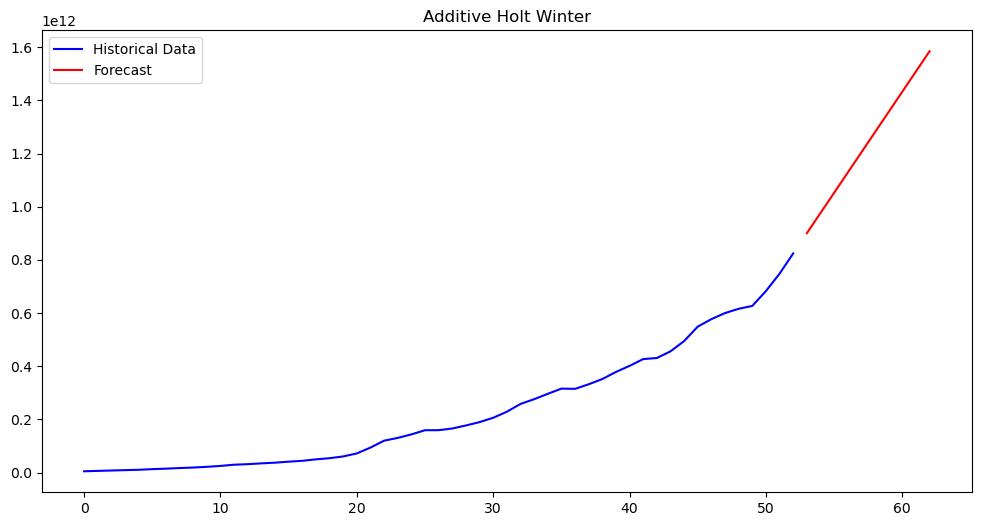

In [148]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['spending'], label='Historical Data', color='blue')
plt.plot(arima_predict.index, arima_predict, label='Forecast', color='red')
plt.title('Additive Holt Winter')
plt.legend()

In [142]:
model = ExponentialSmoothing(data['spending'],trend = 'add').fit()
prediction = model.forecast(10)
prediction

53    8.996296e+11
54    9.750782e+11
55    1.050527e+12
56    1.125975e+12
57    1.201424e+12
58    1.276872e+12
59    1.352321e+12
60    1.427770e+12
61    1.503218e+12
62    1.578667e+12
dtype: float64

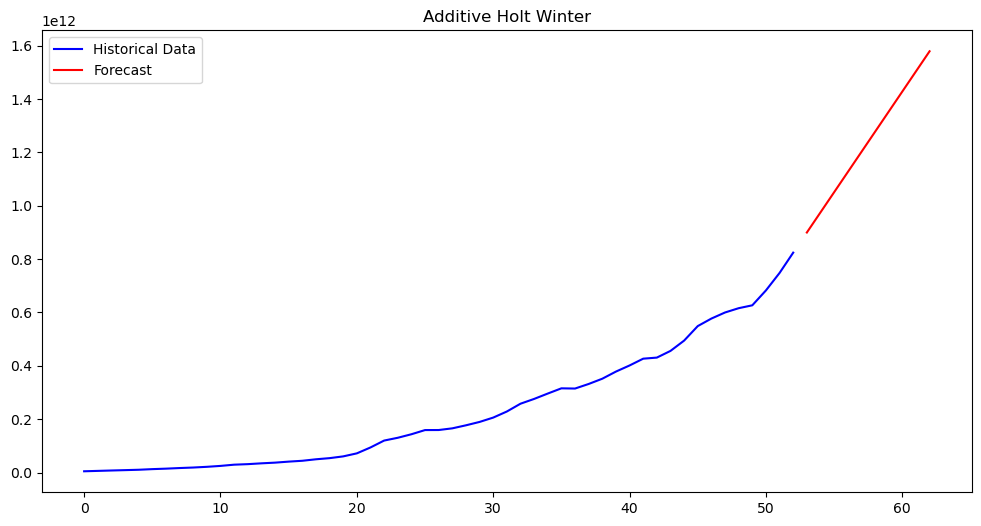

In [144]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['spending'], label='Historical Data', color='blue')
plt.plot(prediction.index, prediction, label='Forecast', color='red')
plt.title('Additive Holt Winter')
plt.legend()

In [133]:
model = ExponentialSmoothing(data['spending'],trend = 'mul').fit()
prediction = model.forecast(10)
prediction

53    9.074174e+11
54    9.990243e+11
55    1.099879e+12
56    1.210916e+12
57    1.333162e+12
58    1.467749e+12
59    1.615923e+12
60    1.779056e+12
61    1.958658e+12
62    2.156391e+12
dtype: float64

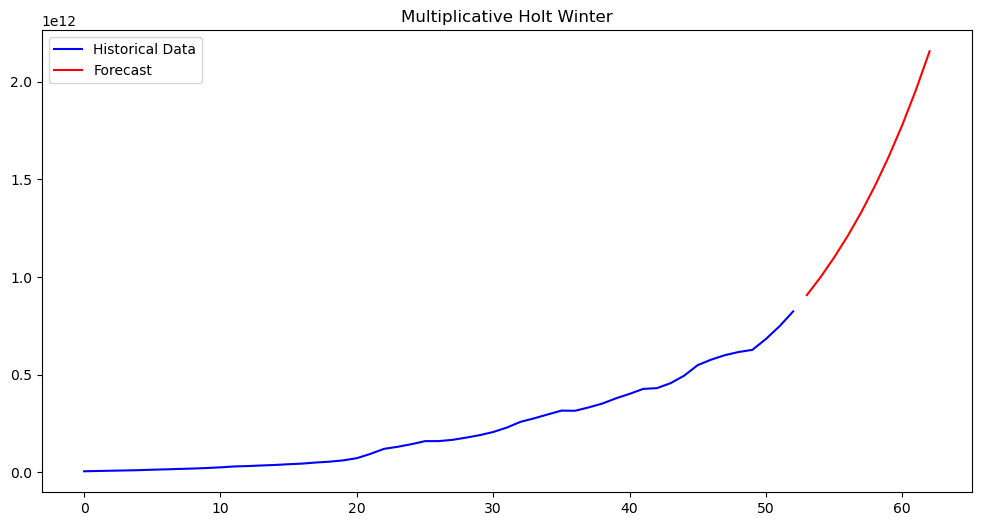

In [141]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['spending'], label='Historical Data', color='blue')
plt.plot(prediction.index, prediction, label='Forecast', color='red')
plt.title('Multiplicative Holt Winter')
plt.legend()

In [134]:
data.tail(10)

,date,spending
43,2013-01-01,4.560386e+11
44,2014-01-01,4.946800e+11
45,2015-01-01,5.490622e+11
46,2016-01-01,5.772512e+11
47,2017-01-01,6.000432e+11
48,2018-01-01,6.160970e+11
49,2019-01-01,6.269300e+11
50,2020-01-01,6.827060e+11
51,2021-01-01,7.482187e+11
52,2022-01-01,8.242363e+11
